In [26]:
from __future__ import annotations

import hashlib
from pathlib import Path
import os, json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from transformers import AutoModelForSequenceClassification, Trainer
from datasets import Dataset
import torch


from datasets import Dataset
from transformers import AutoTokenizer
import evaluate

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)


In [27]:
EXPERIMENTS_DIR = Path("experiments")
EXPERIMENTS_DIR.mkdir(parents=True, exist_ok=True)

METRICS_PATH = EXPERIMENTS_DIR / "metrics_long.csv"   # long format: (experiment_id x class)
RUNS_PATH    = EXPERIMENTS_DIR / "runs_global.csv"    # one row per experiment run

DATA_DIR = Path("data") 

In [28]:
def load_or_empty_csv(path, columns):
    if path.exists():
        return pd.read_csv(path)
    return pd.DataFrame(columns=columns)


def append_and_dedup(df_old, df_new, subset):
    out = pd.concat([df_old, df_new], ignore_index=True)
    out = out.drop_duplicates(subset=subset, keep="last")
    return out

def save_confusion_matrices(experiment_id, cm_raw, cm_norm):
    out_dir = EXPERIMENTS_DIR / experiment_id
    out_dir.mkdir(parents=True, exist_ok=True)
    np.save(out_dir / "confusion_raw.npy", cm_raw)
    np.save(out_dir / "confusion_norm.npy", cm_norm)

def log_run_global(experiment_id, cfg, global_metrics):
    cols = ["experiment_id", "config_json", "accuracy", "macro_f1", "weighted_f1"]
    df_old = load_or_empty_csv(RUNS_PATH, cols)

    row = {
        "experiment_id": experiment_id,
        "config_json": json.dumps(cfg, sort_keys=True),
        **global_metrics,
    }
    df_new = pd.DataFrame([row], columns=cols)
    df_out = append_and_dedup(df_old, df_new, subset=["experiment_id"])
    df_out.to_csv(RUNS_PATH, index=False)

def log_metrics_long(experiment_id, cfg, report_dict, train_counts, id2label=None):
    # Minimal per-class columns that are always meaningful
    base_cols = [
        "experiment_id", "class_id",
        "precision", "recall", "f1", "support_val",
        "n_train_class",
        "config_json",
    ]

    # Optional "nice-to-have" columns (only filled if present)
    optional_cols = [
        "vectorizer",
        "model",
        "class_weight",
        "analyzer", "ngram_min", "ngram_max", "max_features",   # single-vectorizer case
        "word_ngram_min", "word_ngram_max", "word_max_features", "word_min_df",
        "char_ngram_min", "char_ngram_max", "char_max_features", "char_min_df",
    ]

    cols = base_cols + optional_cols

    df_old = load_or_empty_csv(METRICS_PATH, cols)

    rows = []
    cfg_json = json.dumps(cfg, sort_keys=True)

    for k, v in report_dict.items():
        if k in ("accuracy", "macro avg", "weighted avg"):
            continue

        integer_class_id = int(k)
        
        # Map to real class ID if id2label is provided
        if id2label is not None and str(integer_class_id) in id2label:
            real_class_id = id2label[str(integer_class_id)]
        else:
            real_class_id = str(integer_class_id)
        
        print(f"Logging metrics for class_id: {real_class_id} (integer ID: {integer_class_id})")

        row = {
            "experiment_id": experiment_id,
            "class_id": real_class_id,
            "precision": float(v["precision"]),
            "recall": float(v["recall"]),
            "f1": float(v["f1-score"]),
            "support_val": int(v["support"]),
            "n_train_class": int(train_counts.get(str(integer_class_id), 0)),
            "config_json": cfg_json,
        }

        # Fill optional keys if they exist; otherwise leave blank/NaN
        for key in optional_cols:
            if key in cfg:
                row[key] = cfg[key]

        rows.append(row)

    df_new = pd.DataFrame(rows, columns=cols)

    # If old file has fewer columns (from earlier runs), align columns before concat
    for c in df_old.columns:
        if c not in df_new.columns:
            df_new[c] = np.nan
    for c in df_new.columns:
        if c not in df_old.columns:
            df_old[c] = np.nan

    df_new = df_new[df_old.columns]  # same order
    df_out = append_and_dedup(df_old, df_new, subset=["experiment_id", "class_id"])
    df_out.to_csv(METRICS_PATH, index=False)

In [29]:
# Load experiment metrics
experiment_id = "mmBERT-base_20260121_143809"
experiment_path = EXPERIMENTS_DIR / experiment_id

# Load evaluation metrics
with open(experiment_path / "eval_metrics.json", "r") as f:
    eval_metrics = json.load(f)

# Load training metrics
with open(experiment_path / "train_metrics.json", "r") as f:
    train_metrics = json.load(f)

print(f"=== Experiment: {experiment_id} ===\n")
print("Evaluation Metrics:")
print(f"  Accuracy: {eval_metrics['eval_accuracy']:.4f} ({eval_metrics['eval_accuracy']*100:.2f}%)")
print(f"  F1 Macro: {eval_metrics['eval_f1_macro']:.4f} ({eval_metrics['eval_f1_macro']*100:.2f}%)")
print(f"  Loss: {eval_metrics['eval_loss']:.4f}")
print(f"  Runtime: {eval_metrics['eval_runtime']:.2f}s")
print(f"  Samples/sec: {eval_metrics['eval_samples_per_second']:.2f}")

print("\nTraining Metrics:")
print(f"  Loss: {train_metrics['train_loss']:.4f}")
print(f"  Runtime: {train_metrics['train_runtime']:.2f}s ({train_metrics['train_runtime']/60:.2f} min)")
print(f"  Samples/sec: {train_metrics['train_samples_per_second']:.2f}")
print(f"  Epochs: {train_metrics['epoch']}")

=== Experiment: mmBERT-base_20260121_143809 ===

Evaluation Metrics:
  Accuracy: 0.8964 (89.64%)
  F1 Macro: 0.8861 (88.61%)
  Loss: 0.9622
  Runtime: 86.93s
  Samples/sec: 192.11

Training Metrics:
  Loss: 0.6546
  Runtime: 2868.33s (47.81 min)
  Samples/sec: 93.16
  Epochs: 4.0


# Load Best Model and Evaluate Per-Class Performance

In [30]:
# overall metrics and per-class metrics saved to CSV

def compute_metrics_local(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"],
    }


experiment_ids = [str(d.name) for d in Path(EXPERIMENTS_DIR).iterdir() if d.is_dir()]
print("Found experiment IDs:", experiment_ids)
# experiment_ids = ["mmBERT-base_20260121_143809"]
# print("Found experiment IDs:", experiment_ids)
# print("Found experiment IDs:", experiment_ids)

for experiment_id in experiment_ids:
    runs_df = load_or_empty_csv(RUNS_PATH, ["experiment_id"])
    if experiment_id in runs_df["experiment_id"].values:
        print(f"Experiment {experiment_id} already logged in runs CSV. Skipping.")
        continue

    # loading model and evaluating global metrics
    BEST_DIR = EXPERIMENTS_DIR / experiment_id / "best_model"
    print(f"Loading best model from: {BEST_DIR}")
    best_model = AutoModelForSequenceClassification.from_pretrained(str(BEST_DIR)) 
    CFG = json.load(open(EXPERIMENTS_DIR / experiment_id / "cfg.json", "r"))
    
    # Load label map
    label_map_path = EXPERIMENTS_DIR / experiment_id / "label_map.json"
    if label_map_path.exists():
        with open(label_map_path, "r") as f:
            label_map = json.load(f)
            id2label = label_map.get("id2label", {})
    else:
        id2label = None
    
    training_args = torch.load(os.path.join(BEST_DIR, "training_args.bin"), weights_only=False)
    train_tok = Dataset.load_from_disk(os.path.join(BEST_DIR, "train_dataset"))
    val_tok = Dataset.load_from_disk(os.path.join(BEST_DIR, "val_dataset"))
    tokenizer = AutoTokenizer.from_pretrained(BEST_DIR, use_fast=False)

    # Reload evaluate metrics to avoid variable shadowing
    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")

    best_trainer = Trainer( model=best_model, args=training_args, train_dataset=train_tok, eval_dataset=val_tok, tokenizer=tokenizer, compute_metrics=compute_metrics_local ) 
    print(train_tok[0])
    best_eval_out = best_trainer.evaluate() 
    print(f"Model {experiment_id} eval results:", best_eval_out)

    # Predict on validation
    pred = best_trainer.predict(val_tok)
    y_pred = np.argmax(pred.predictions, axis=1)
    y_true = pred.label_ids

    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    # confusion matrix
    labels_sorted = np.sort(np.unique(y_true))
    cm_raw = confusion_matrix(y_true, y_pred, labels=labels_sorted)
    cm_norm = cm_raw.astype("float") / cm_raw.sum(axis=1)[:, np.newaxis]
    save_confusion_matrices(experiment_id, cm_raw, cm_norm)
    
    # save per-class metrics to long CSV
    # get training counts per class
    train_counts = {}
    for item in train_tok:
        label_id = item["label"]
        train_counts[str(label_id)] = train_counts.get(str(label_id), 0) + 1
    
    log_metrics_long(experiment_id, CFG, report, train_counts, id2label=id2label)
    log_run_global(experiment_id, CFG, {
        "accuracy": best_eval_out["eval_accuracy"],
        "macro_f1": best_eval_out["eval_f1_macro"],
        "weighted_f1": best_eval_out.get("eval_f1_weighted", np.nan),
    })
    

    # 3) Extract per-class F1 in sorted order
    # report keys for classes are strings of the label ids: "0", "1", ...
    class_keys = sorted([k for k in report.keys() if k.isdigit()], key=lambda x: int(x))
    class_ids = [int(k) for k in class_keys]
    f1_per_class = [report[k]["f1-score"] for k in class_keys]
    support_per_class = [report[k]["support"] for k in class_keys]

    # Optional: if you have an id2label dict (e.g., best_model.config.id2label)
    # use names instead of numeric ids
    id2label = getattr(best_model.config, "id2label", None)
    if isinstance(id2label, dict) and len(id2label) > 0:
        x_labels = [id2label.get(i, str(i)) for i in class_ids]
    else:
        x_labels = [str(i) for i in class_ids]



Found experiment IDs: ['mmBERT-base_20260122_135823', 'mmBERT-base_20260122_133831', 'mmBERT-base_20260122_131611', 'mmBERT-base_20260122_114329', 'mmBERT-base_20260122_013213', 'mmBERT-base_20260122_012030', 'mmBERT-base_20260122_004952', 'mmBERT-base_20260122_002353', 'mmBERT-base_20260122_000205', 'mmBERT-base_20260121_233752', 'mmBERT-base_20260121_232021', 'mmBERT-base_20260121_230838', 'mmBERT-base_20260121_223843', 'mmBERT-base_20260121_221317', 'mmBERT-base_20260121_215136', 'mmBERT-base_20260121_212721', 'mmBERT-base_20260121_210953', 'mmBERT-base_20260121_205810', 'mmBERT-base_20260121_202810', 'mmBERT-base_20260121_200200', 'mmBERT-base_20260121_194016', 'mmBERT-base_20260121_191559', 'mmBERT-base_20260121_185816', 'mmBERT-base_20260121_184633', 'mmBERT-base_20260121_181533', 'mmBERT-base_20260121_174944', 'mmBERT-base_20260121_172741', 'distilbert-base-multilingual-cased_20260121_170821', 'bert-base-multilingual-cased_20260121_165532', 'mdeberta-v3-base_20260121_162755', 'x

The tokenizer you are loading from 'experiments/mmBERT-base_20260122_135823/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
/tmp/ipykernel_10785/3011017222.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_trainer = Trainer( model=best_model, args=training_args, train_dataset=train_tok, eval_dataset=val_tok, tokenizer=tokenizer, compute_metrics=compute_metrics_local )


{'label': 4, 'input_ids': [2, 67656, 235248, 235304, 235258, 163553, 9700, 125957, 33655, 190437, 235248, 235304, 235299, 49721, 22960, 71927, 637, 29516, 1905, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Model mmBERT-base_20260122_135823 eval results: {'eval_loss': 0.6434178352355957, 'eval_model_preparation_time': 0.0021, 'eval_accuracy': 0.8876115202682474, 'eval_f1_macro': 0.8774213226178594, 'eval_runtime': 18.6066, 'eval_samples_per_second': 897.583, 'eval_steps_per_second': 56.109}
Logging metrics for class_id: 10 (integer ID: 0)
Logging metrics for class_id: 1140 (integer ID: 1)
Logging metrics for class_id: 1160 (integer ID: 2)
Logging metrics for class_id: 1180 (integer ID: 3)
Logging metrics for class_id: 1280 (integer ID: 4)
Logging metrics for class_id: 1281 (integer ID: 5)
Logging metrics for class_id: 1300 (integer ID: 6)
Logging metrics for class_id: 1301 (integer ID: 7)
Logging metrics for class_id: 1302 (integer ID: 8)
Logging metrics for class_id: 1320 (integer ID: 9)
Logging metrics for class_id: 1560 (integer ID: 10)
Logging metrics for class_id: 1920 (integer ID: 11)
Logging metrics for class_id: 1940 (integer ID: 12)
Logging metrics for class_id: 2060 (integer ID:

The tokenizer you are loading from 'experiments/mmBERT-base_20260122_133831/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
/tmp/ipykernel_10785/3011017222.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_trainer = Trainer( model=best_model, args=training_args, train_dataset=train_tok, eval_dataset=val_tok, tokenizer=tokenizer, compute_metrics=compute_metrics_local )


{'label': 4, 'input_ids': [2, 67656, 235248, 235304, 235258, 163553, 9700, 125957, 33655, 190437, 235248, 235304, 235299, 49721, 22960, 71927, 637, 29516, 1905, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Model mmBERT-base_20260122_133831 eval results: {'eval_loss': 0.6981520652770996, 'eval_model_preparation_time': 0.0023, 'eval_accuracy': 0.8727022333991976, 'eval_f1_macro': 0.863484175746692, 'eval_runtime': 18.2993, 'eval_samples_per_second': 912.66, 'eval_steps_per_second': 57.051}
Logging metrics for class_id: 10 (integer ID: 0)
Logging metrics for class_id: 1140 (integer ID: 1)
Logging metrics for class_id: 1160 (integer ID: 2)
Logging metrics for class_id: 1180 (integer ID: 3)
Logging metrics for class_id: 1280 (integer ID: 4)
Logging metrics for class_id: 1281 (integer ID: 5)
Logging metrics for class_id: 1300 (integer ID: 6)
Logging metrics for class_id: 1301 (integer ID: 7)
Logging metrics for class_id: 1302 (integer ID: 8)
Logging metrics for class_id: 1320 (integer ID: 9)
Logging metrics for class_id: 1560 (integer ID: 10)
Logging metrics for class_id: 1920 (integer ID: 11)
Logging metrics for class_id: 1940 (integer ID: 12)
Logging metrics for class_id: 2060 (integer ID: 1

The tokenizer you are loading from 'experiments/mmBERT-base_20260122_131611/best_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
/tmp/ipykernel_10785/3011017222.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_trainer = Trainer( model=best_model, args=training_args, train_dataset=train_tok, eval_dataset=val_tok, tokenizer=tokenizer, compute_metrics=compute_metrics_local )


{'label': 4, 'input_ids': [2, 67656, 235248, 235304, 235258, 163553, 9700, 125957, 33655, 190437, 235248, 235304, 235299, 49721, 22960, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Model mmBERT-base_20260122_131611 eval results: {'eval_loss': 0.902580976486206, 'eval_model_preparation_time': 0.0024, 'eval_accuracy': 0.8170768217472008, 'eval_f1_macro': 0.8076230577775192, 'eval_runtime': 23.1123, 'eval_samples_per_second': 722.601, 'eval_steps_per_second': 45.171}
Logging metrics for class_id: 10 (integer ID: 0)
Logging metrics for class_id: 1140 (integer ID: 1)
Logging metrics for class_id: 1160 (integer ID: 2)
Logging metrics for class_id: 1180 (integer ID: 3)
Logging metrics for class_id: 1280 (integer ID: 4)
Logging metrics for class_id: 1281 (integer ID: 5)
Logging metrics for class_id: 1300 (integer ID: 6)
Logging metrics for class_id: 1301 (integer ID: 7)
Logging metrics for class_id: 1302 (integer ID: 8)
Logging metrics for class_id: 1320 (integer ID: 9)
Logging metrics for class_id: 1560 (integer ID: 10)
Logging metrics for class_id: 1920 (integer ID: 11)
Logging metrics for class_id: 1940 (integer ID: 12)
Logging metrics for class_id: 2060 (integer ID: 

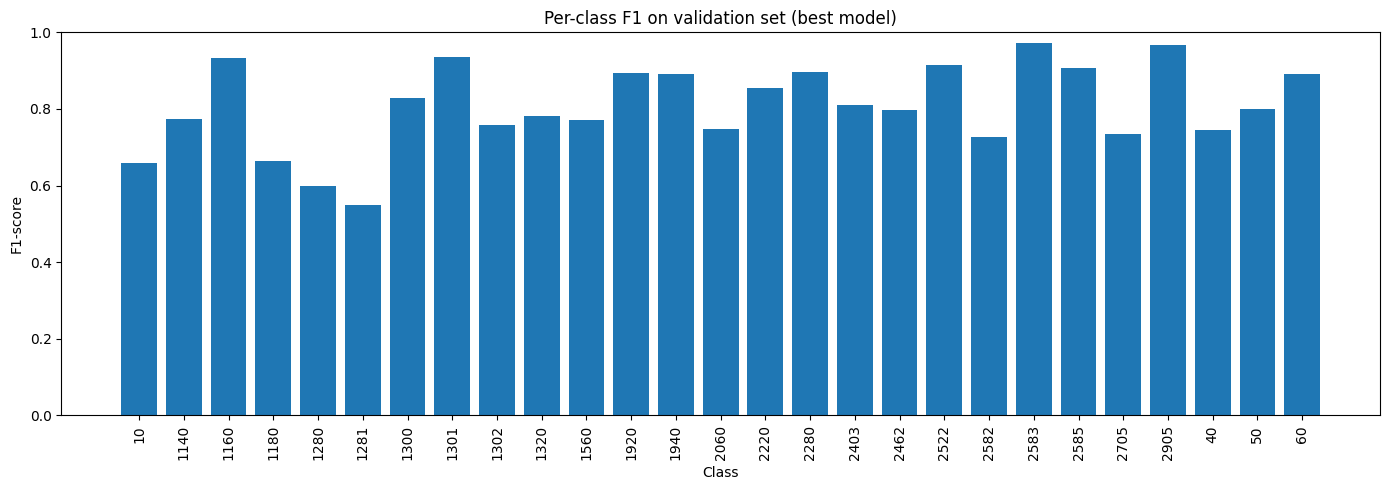

Worst 15 classes (class_id, f1, support):
5 0.5504 408.0
4 0.5987 970.0
0 0.6586 623.0
3 0.6644 153.0
19 0.7276 502.0
22 0.7351 552.0
24 0.7457 497.0
13 0.7473 972.0
8 0.7573 475.0
10 0.7705 1002.0
1 0.7727 534.0
9 0.7816 645.0
17 0.7978 281.0
25 0.8 329.0
16 0.8095 953.0


In [31]:
# 4) Plot
plt.figure(figsize=(14, 5))
plt.bar(range(len(f1_per_class)), f1_per_class)
plt.xticks(range(len(f1_per_class)), x_labels, rotation=90)
plt.ylim(0, 1.0)
plt.ylabel("F1-score")
plt.xlabel("Class")
plt.title("Per-class F1 on validation set (best model)")
plt.tight_layout()
plt.show()

# 5) Quick peek at worst classes
worst = sorted(zip(class_ids, f1_per_class, support_per_class), key=lambda x: x[1])[:15]
print("Worst 15 classes (class_id, f1, support):")
for cid, f1, sup in worst:
    print(cid, round(f1, 4), sup)

